GradCam

1. Imports

In [45]:
# General imports
import os
import yaml
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T
from torch import tensor


# PyTorch and related imports
import torch
from torchvision import models
from torchvision.utils import make_grid, save_image

# Grad-CAM imports
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

# Custom module imports
os.chdir('/home/magali/ct_classifier/ct_classifier')
from train import load_model, create_dataloader
from dataset import CTDataset
from model import CustomResNet18


2. Configuration and Setup

In [46]:
config = '/home/magali/ct_classifier/configs/exp_resnet18_sex.yaml'
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))

dl_val = create_dataloader(cfg, split='val')
model = load_model(cfg)[0]
#model_weights_path = '../best_models/sex_basic_pad_flip_col_rndPers_norm_200ep_run1_198.pt' #/home/magali/ct_classifier/best_models/sex_basic_pad_flip_col_rndPers_norm_200ep_run1_198.pt
#model.load_state_dict(torch.load(model_weights_path))
#model.eval()

# Loading the full state dict
checkpoint = torch.load('../best_models/sex_basic_pad_flip_col_rndPers_norm_200ep_run1_198.pt')
# Extracting only the model weights
model_weights = checkpoint['model']
# Initialize your model instance
model = CustomResNet18(cfg['num_classes'])
# Load the model weights
model.load_state_dict(model_weights)

model.eval()


device = cfg['device']
model.to(device)

Using config "/home/magali/ct_classifier/configs/exp_resnet18_sex.yaml"
val number of images 1540 labels 1540 images covered 1540
Starting new model


CustomResNet18(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

3. Image Preprocessing

In [74]:
img_path = '/home/magali/CV4Ecology-summer-school/PrototypeCroppedImages/PrototypeCroppedImages_Sex_Val/772_cropped.jpg'
img = Image.open(img_path).convert('RGB')

# Image Padding and Resizing
w, h = img.size
img_max_dim = max(w, h)
pad_amount_x = int((img_max_dim - w) / 2)
pad_amount_y = int((img_max_dim - h) / 2)
transform_pad_resize = T.Compose([
    T.Pad([pad_amount_x, pad_amount_y]),
    T.Resize(cfg['image_size']),
    #T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.5)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=.5, hue=.3),
    T.RandomPerspective(distortion_scale=0.5, p=0.5),
    #T.RandomGrayscale(p=.5),
    T.ToTensor(),
    T.Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
])
padded_img = transform_pad_resize(img)
padded_img_np = np.transpose(padded_img.cpu().numpy(), (1, 2, 0))


4. Grad-CAM Application

In [75]:
target_layer = model.feature_extractor.layer4[1].conv2
cam = GradCAM(arch=model, target_layer=target_layer)
#mask, logit = cam(padded_img, class_idx=None)
padded_img_with_batch = padded_img.unsqueeze(0).to(device)
mask, logit = cam(padded_img_with_batch, class_idx=None)

# Getting the heatmap (saliency map) and logit using the GradCAM instance
heatmap, result = visualize_cam(mask, padded_img_with_batch)
heatmap = mask.cpu().numpy()
# Convert PyTorch tensor to numpy array
result_np = result.cpu().numpy()
result_np = np.transpose(result_np, (1, 2, 0))

# Rescale and convert data type
result_np = (result_np * 255).astype(np.uint8)


5. Visualization

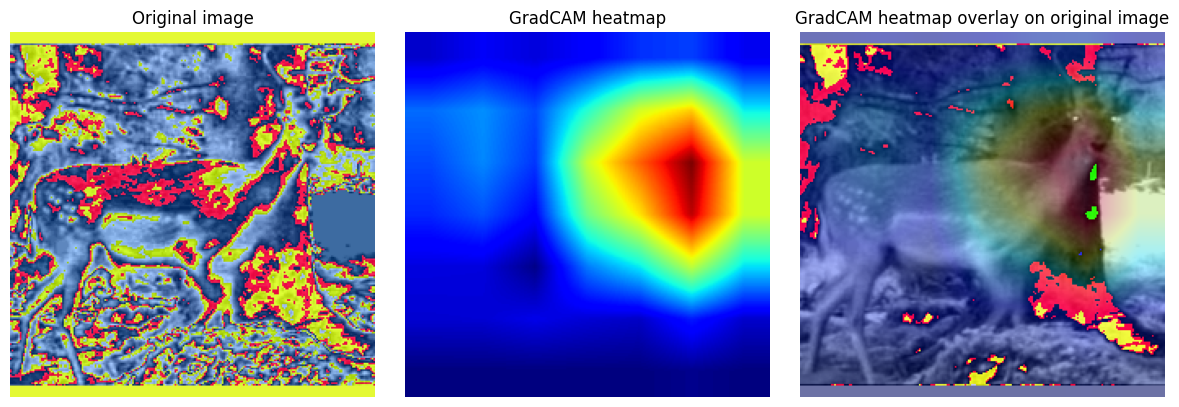

In [76]:
# for the orginal image
#padded_img_from_tensor = T.ToPILImage()(padded_img.cpu())
padded_img_from_tensor = T.ToPILImage()(padded_img_with_batch.squeeze(0).cpu())

# Visualizing the heatmap
heatmap = mask.squeeze().cpu().numpy()
heatmap_colored = plt.cm.jet(heatmap)[...,:3]  # Convert heatmap to RGB format

# Create overlay of heatmap on original image
#alpha = 0.5  # Set the transparency level (between 0 and 1)
#overlay = (heatmap_colored * alpha + np.array(padded_img_from_tensor) * (1 - alpha)).astype(np.uint8)

# Plotting
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Original Image
axarr[0].imshow(padded_img_from_tensor)
axarr[0].title.set_text('Original image')
axarr[0].axis('off')

# Heatmap
axarr[1].imshow(heatmap_colored)
axarr[1].title.set_text('GradCAM heatmap')
axarr[1].axis('off')

# Overlay
axarr[2].imshow(result_np)
axarr[2].title.set_text('GradCAM heatmap overlay on original image')
axarr[2].axis('off')

plt.tight_layout()
plt.show()
